In [1]:
import numpy as np
import time

# generate data

In [2]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

# write your model class

### 用SMO优化

In [3]:
def clipAlpha(aj, H, L):  # 得到截断解
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj
class SVM1:
    def __init__(self, m, C, toler, random_select_alpha_j=True, delta=1e-5, max_iter=4):
        """
        You can add some other parameters, which I think is not necessary
        m: 数据数量
        alpha,b: 待优化参数
        toler: 用于软间隔
        random_select_alpha_j: 如何选定第二个alpha, True->随机选择
        delta: alpha更新是否够大
        max_iter: 最大迭代数目
        """
        self.m = m
        self.alpha = np.mat(np.zeros((m, 1)))
        self.b = 0
        self.E_cashe = np.zeros((self.m, 2))  # 缓存误差E
        self.C = C
        self.toler = toler
        self.alpha_delta = delta
        self.maxiter = max_iter
        self.w = None
        self.random_select = random_select_alpha_j

    def fit(self, X, label):
        """
        Fit the coefficients via your methods
        最终得到的b, w用来进行预测
        """
        # 因为update_para里面有KKT条件判断, 因此这里就直接遍历就行, 在里面判断KKT
        iter = 0
        while iter < self.maxiter:
            alphaPairsChanged = 0
            for i in range(self.m):
                alphaPairsChanged += self.update_para(i, label, X)  # 调用内循环
            iter += 1  # 无论是否更新过，我们都计算迭代一次
        print("iteration number: %d" % iter)

        mid_result = np.multiply(self.alpha, label)
        self.w = np.sum(np.multiply(mid_result, X), axis=0)  # shape: (1,25)

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        y = np.sign(X * self.w.T + self.b)
        return y

    def cal_Ek(self, label, k, X):
        # 计算Ek
        fxk = np.multiply(self.alpha, label).T @ (X @ X[k, :]) + self.b
        Ek = fxk - label[k]
        return Ek

    def update_Ek(self, label, k, X):
        # 更新Ek
        Ek = self.cal_Ek(label, k, X)
        self.E_cashe[k][0] = 1  # 第一列1，表示为有效标识
        self.E_cashe[k][1] = Ek

    def select_j(self, i, Ei, label, X):
        """
        在已知一个alpha的情况下寻找第二个alpha, i.e. max{|Ei-Ej|}
        """
        max_j = -1  # 用于保存临时最大索引
        maxDeltaE = 0  # 用于保存临时最大差值--->|Ei-Ej|
        Ej = 0

        self.E_cashe[i][0] = 1  # 第一列1，表示为有效标识
        self.E_cashe[i][1] = Ei

        # 开始获取各个Ek值，比较|Ei-Ej|获取Ej的所有
        # 获取所有有效的Ek值对应的索引
        validECacheList = np.where(self.E_cashe[:, 0] != 0)[0]  # 根据误差缓存中第一列非0，获取对应的有效误差值
        # 这种方法不推荐！
        if len(validECacheList) > 1 and not self.random_select:
            for k in validECacheList:
                if k == i:  # 相同则不处理
                    continue
                # 开始计算Ek值，进行对比，获取最大差值
                Ek = self.cal_Ek(label, k, X)
                deltaE = abs(Ei - Ek)
                if deltaE > maxDeltaE:  # 更新Ej及其索引位置
                    max_j = k
                    maxDeltaE = deltaE
                    Ej = Ek
            return max_j, Ej  # 返回我们找到的第二个变量α_2的位置
        else:
            j = i
            while j == i:
                j = int(np.random.uniform(0, self.m))  # 从0~m中随机选取一个数，是进行整数化的
            Ej = self.cal_Ek(label, j, X)
            return j, Ej

    def update_para(self, i, label, X):
        Ei = self.cal_Ek(label, i, X)
        # gi = self.cal_gk(label, i, X)
        # 下面需要检查是否违背KKT条件:
        if ((label[i] * Ei < -self.toler) and (self.alpha[i] < self.C)) or \
                ((label[i] * Ei > self.toler) and (self.alpha[i] > 0)):
            # 违背KKT条件
            # --------------检测区域1--START(详情见报告)---------------
            j, Ej = self.select_j(i, Ei, label, X)
            alpha_i_old = self.alpha[i]
            alpha_j_old = self.alpha[j]  # 保存2个值

            # --------------检测区域1--END(详情见报告)---------------

            # 下面要更新alpha_2, 首先计算出截断边界, 判断两者是否同号:
            # --------------检测区域2--START(详情见报告)---------------
            if label[i] != label[j]:
                L = max(0, alpha_j_old - alpha_i_old)
                H = min(self.C, self.C + alpha_j_old - alpha_i_old)
            else:
                L = max(0, alpha_j_old + alpha_i_old - self.C)
                H = min(self.C, alpha_j_old + alpha_i_old)
            if L == H:  # 如果L==H，之间返回0，跳出这次循环，不进行改变(单值选择，没必要）
                return 0

            # 计算未截断的alpha_2, 计算要素: E1,E2,K11,K12,K22
            # 设 η=K11+K22-2K12 可以化为完全平方式.
            eta = X[i] @ X[i] + X[j] @ X[j] - 2.0 * X[i] @ X[j]
            if eta == 0:
                return 0
            # 未截断alpha_2:
            self.alpha[j] += label[j] * (Ei - Ej) / eta
            self.alpha[j] = clipAlpha(self.alpha[j], H, L)
            self.update_Ek(label, j, X)
            # --------------检测区域2--END(详情见报告)---------------

            # 因此如果小于delta, 不进行alpha_1更新
            if abs(self.alpha[j] - alpha_j_old) < self.alpha_delta:
                return 0
            # alpha_1可以根据alpha_2算得
            self.alpha[i] += label[i] * label[j] * (alpha_j_old - self.alpha[j])
            # alpha更新, 故更新一次E_i
            self.update_Ek(label, i, X)
            # 更新b, 有现成的公式, 照着写就ok
            b1 = self.b - Ei - label[i] * (self.alpha[i] - alpha_i_old) * X[i] @ X[i] - label[j] * (
                    self.alpha[j] - alpha_j_old) * X[i] @ X[j]

            b2 = self.b - Ej - label[i] * (self.alpha[i] - alpha_i_old) * X[i] @ X[j] - label[j] * (
                    self.alpha[j] - alpha_j_old) * X[j] @ X[j]
            # 根据《统计学习方法》更新b
            if 0 < self.alpha[i] < self.C:
                self.b = b1
            elif 0 < self.alpha[j] < self.C:
                self.b = b2
            else:
                self.b = 1 / 2 * (b1 + b2)
            return 1

        else:
            # 不违背KKT条件
            return 0

In [4]:
# you can do anything necessary about the model
class SVM2_gd:
    def __init__(self, m, C, lr=0.001, max_iter=1e5):
        self.m = m
        self.b = 0
        self.C = C
        self.lr = lr
        self.max_iter = max_iter
        self.w = None

    def fit(self, x, y):
        self.w = np.zeros((1, x.shape[1]))
        for i in range(int(self.max_iter)):
            self.w *= 1 - self.lr
            err = 1 - y * self.predict(x, need_sign=False)
            idx = np.argmax(err)
            if err[idx] <= 0:
                continue
            delta = self.lr * self.C * y[idx]
            self.w = (1 - self.lr) * self.w + delta * x[idx]
            self.b += delta

    def predict(self, X, need_sign=True):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        if need_sign:
            return np.sign(np.dot(X, self.w.T) + self.b)
        else:
            return np.dot(X, self.w.T) + self.b

In [5]:
def acc_cal(y_ground, y_pred):
    # y_pred = (y_pred >= 0).astype(np.int64) - (y_pred < 0).astype(np.int64)
    return np.sum((y_ground.squeeze()==y_pred.squeeze())) / y_ground.shape[0]

# construct and train your models

In [51]:
# generate data
X_data, y_data, mislabel = generate_data(dim=20, num=10000)
print(mislabel)
# split data
# 就按照4:1进行划分
split = int(4*X_data.shape[0]/5)
X_train = X_data[:split, :]
X_test = X_data[split:, :]
y_train = y_data[:split]
y_test = y_data[split:]

0.0391


# predict and compare your results

## 第一种方法: SMO.

##### 注:我的错标率是0.0398
我实际进行了3轮iteration, 在3.58s的时间里达到91.95%的准确率, 证明了模型的正确性.
准确率: 91.95% (SMO, our method) v.s. 95.8% (sklearn)
运行时间: 3.58s (SMO, our method) v.s. 25.48s (sklearn). 我的运行时间快很多.
上面即为我的SMO优化与sklearn的对比, sklearn采用linear kernel.
我使用的`max_iter`为3, 如果将sklearn的`max_iter`也设置为3, 则sklearn的(准确率,运行时间)=(62.95%,0.007). 这种情况下我的准确率又高很多.

In [19]:
print(y_test.shape[0])
SVM = SVM1(X_train.shape[0], C=5, toler=0, max_iter=3)
time_start = time.time()
SVM.fit(X_train, y_train)
time_end = time.time()
print(time_end - time_start)
pred = SVM.predict(X_test)
print(acc_cal(y_test, pred))

2000
iteration number: 3
3.5864064693450928
0.9195


## 第二种方法: gradient descent
在7.7s的时间里达到76%的准确率, 这个方法在我这里就不如SMO. 当然也是因为我没有加更多的东西(只写了最基本的GD).
运行时间和准确率都比我的SMO方法要低很多.


In [53]:
SVM_2 = SVM2_gd(X_train.shape[0], C=5)
time_start = time.time()
SVM_2.fit(X_train, y_train)
time_end = time.time()
print(time_end - time_start)
pred = SVM_2.predict(X_test)
print(acc_cal(y_test, pred))

7.776864767074585
0.714


## 与sklearn的比较

In [12]:
# 这里和sklearn进行比较
from sklearn.svm import SVC
svm_model = SVC(kernel = 'linear', max_iter=4)

time_start = time.time()
svm_model.fit(X_train,y_train)
time_end = time.time()

pred_lib = svm_model.predict(X_test)

acc = acc_cal(y_test, pred_lib)
time_c= time_end - time_start
acc, time_c

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=4).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


(0.6295, 0.0069828033447265625)

## 实验探究

#### 主要内容: 软间隔`toler`, 数据量, 数据维度.


首先固定数据维度为15, 数据量在[10, 50, 100, 200, 500, 1000, 3000, 5000, 7500, 10000]的准确率变化
红线是SMO方法, 蓝线是GD. 可以看出随着数据量增长, 时间损耗上GD的增长速度要更快；在准确率上，数量较小时两者准确率都有明显提升（这是因为我的维度设置为15），而后维持在一定水平。且SMO在稳定性和大小上都要明显好于GD

iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3


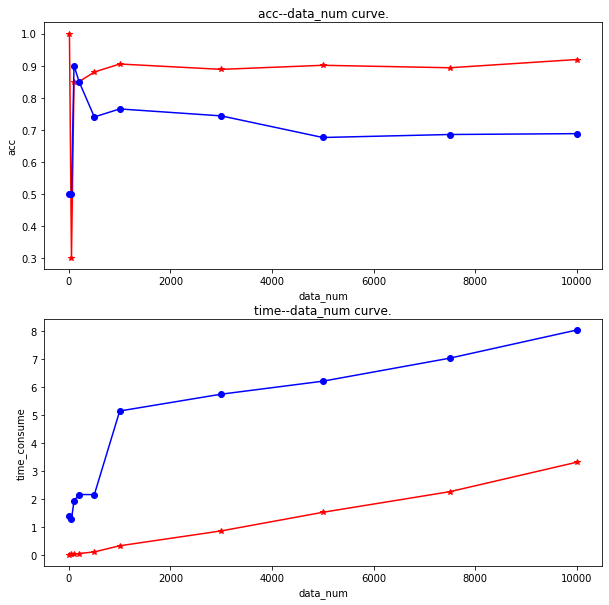

In [14]:
import matplotlib.pyplot as plt

data_num = [10, 50, 100, 200, 500, 1000, 3000, 5000, 7500, 10000]
predict_smo=[]
predict_gd = []
time_smo = []
time_gd = []
mis_list = []
for item in data_num:
    # generate data
    X_data, y_data, mislabel = generate_data(dim=15, num=item)
    mis_list.append(mislabel)
    split = int(4*X_data.shape[0]/5)
    X_train = X_data[:split, :]
    X_test = X_data[split:, :]
    y_train = y_data[:split]
    y_test = y_data[split:]
    SVM = SVM1(X_train.shape[0], C=5, toler=0, max_iter=3)
    time_start = time.time()
    SVM.fit(X_train, y_train)
    time_end = time.time()
    time_smo.append(time_end-time_start)
    pred = SVM.predict(X_test)
    predict_smo.append(acc_cal(y_test, pred))

    SVM_2 = SVM2_gd(X_train.shape[0], C=5)
    time_start = time.time()
    SVM_2.fit(X_train, y_train)
    time_end = time.time()
    time_gd.append(time_end-time_start)
    pred = SVM_2.predict(X_test)
    predict_gd.append(acc_cal(y_test, pred))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(data_num,predict_smo,marker="*",label='SMO',color='r')
plt.plot(data_num,predict_gd,marker='o',label='GD', color='b')
plt.xlabel("data_num")
plt.ylabel("acc")
plt.title("acc--data_num curve.")

plt.subplot(212)
plt.plot(data_num,time_smo,marker="*",label='SMO',color='r')
plt.plot(data_num,time_gd,marker='o',label='GD', color='b')
plt.xlabel("data_num")
plt.ylabel("time_consume")
plt.title("time--data_num curve.")

plt.show()

iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3


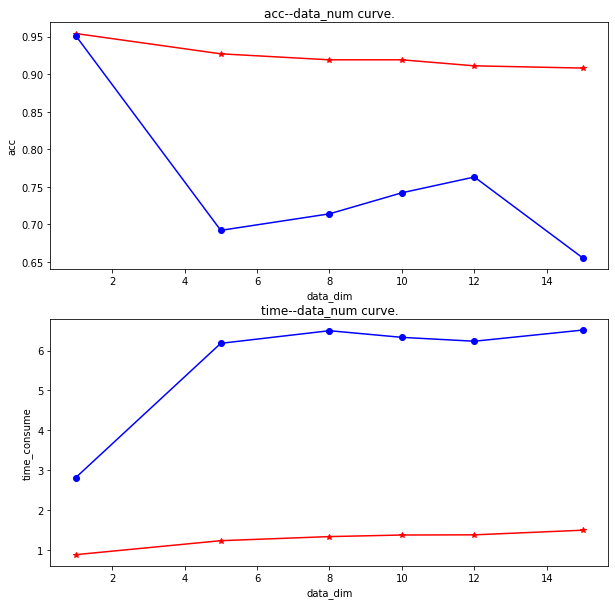

In [12]:
import matplotlib.pyplot as plt

data_dim = [1, 5, 8, 10, 12, 15]
predict_smo=[]
predict_gd = []
time_smo = []
time_gd = []
mis_list = []
for item in data_dim:
    # generate data
    X_data, y_data, mislabel = generate_data(dim=item, num=5000)
    split = int(4*X_data.shape[0]/5)
    X_train = X_data[:split, :]
    X_test = X_data[split:, :]
    y_train = y_data[:split]
    y_test = y_data[split:]
    SVM = SVM1(X_train.shape[0], C=5, toler=0, max_iter=3)
    time_start = time.time()
    SVM.fit(X_train, y_train)
    time_end = time.time()
    time_smo.append(time_end-time_start)
    pred = SVM.predict(X_test)
    predict_smo.append(acc_cal(y_test, pred))

    SVM_2 = SVM2_gd(X_train.shape[0], C=5)
    time_start = time.time()
    SVM_2.fit(X_train, y_train)
    time_end = time.time()
    time_gd.append(time_end-time_start)
    pred = SVM_2.predict(X_test)
    predict_gd.append(acc_cal(y_test, pred))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(data_dim,predict_smo,marker="*",label='SMO',color='r')
plt.plot(data_dim,predict_gd,marker='o',label='GD', color='b')
plt.xlabel("data_dim")
plt.ylabel("acc")
plt.title("acc--data_num curve.")

plt.subplot(212)
plt.plot(data_dim,time_smo,marker="*",label='SMO',color='r')
plt.plot(data_dim,time_gd,marker='o',label='GD', color='b')
plt.xlabel("data_dim")
plt.ylabel("time_consume")
plt.title("time--data_num curve.")

plt.show()

iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3
iteration number: 3


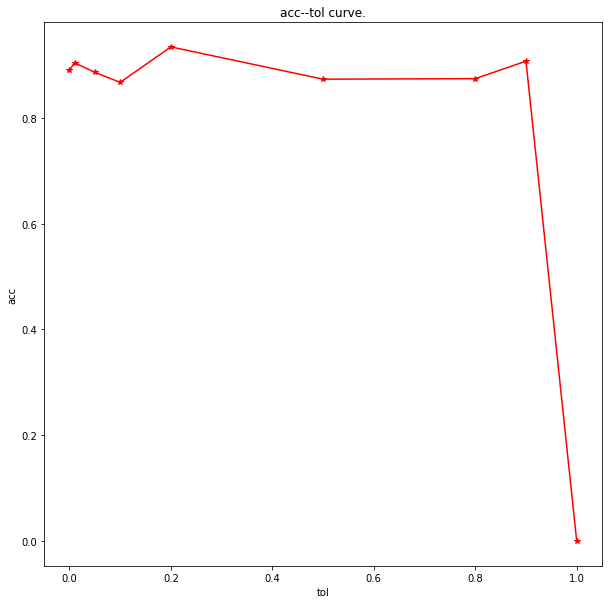

In [13]:
import matplotlib.pyplot as plt
X_data, y_data, mislabel = generate_data(dim=15, num=5000)
split = int(4*X_data.shape[0]/5)
X_train = X_data[:split, :]
X_test = X_data[split:, :]
y_train = y_data[:split]
y_test = y_data[split:]
tol_list = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1]
predict_smo=[]
for item in tol_list:
    # generate data
    SVM = SVM1(X_train.shape[0], C=5, toler=item, max_iter=3)
    SVM.fit(X_train, y_train)
    pred = SVM.predict(X_test)
    predict_smo.append(acc_cal(y_test, pred))
plt.figure(figsize=(10,10))
plt.plot(tol_list,predict_smo,marker="*",label='SMO',color='r')
plt.xlabel("tol")
plt.ylabel("acc")
plt.title("acc--tol curve.")
plt.show()